# **2. EDA**

## Imports

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

In [45]:
df = pd.read_csv('data/data_eda.csv')

In [46]:
df.head()

,Date,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Type,Size
0,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1,24924.50,A,151315
1,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,50605.27,A,151315
2,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,3,13740.12,A,151315
3,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,4,39954.04,A,151315
4,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5,32229.38,A,151315


### Correlations

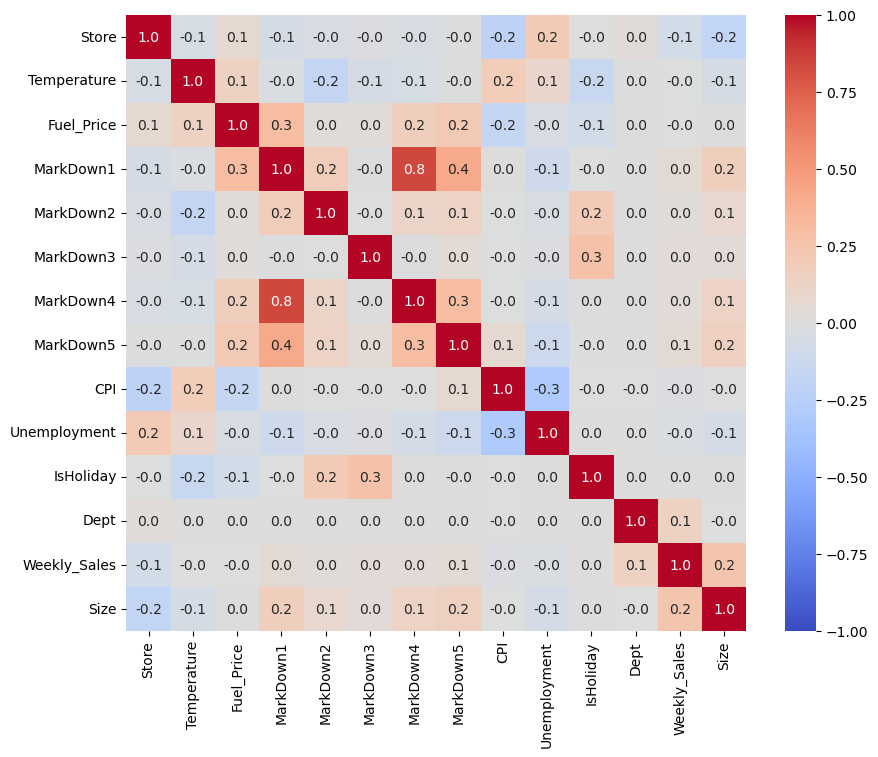

In [47]:
# Corr heatmap
plt.figure(figsize = (10,8))
sns.heatmap(df.drop(columns=['Date', 'Type']).corr(), annot=True, fmt='.1f', vmin = -1, vmax = 1, cmap='coolwarm');

Size, dept and Markdown 5 have highest corr with weekly sales

### Total Sales

In [48]:
total_store_sales = df.groupby('Date')['Weekly_Sales'].sum()

In [49]:
total_store_sales

Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
                 ...     
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Name: Weekly_Sales, Length: 143, dtype: float64

In [50]:
total_store_sales = pd.DataFrame(total_store_sales)

In [51]:
total_store_sales.reset_index(inplace=True)

In [52]:
total_store_sales['Date'] = pd.to_datetime(total_store_sales['Date'])

In [53]:
total_store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   Weekly_Sales  143 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [54]:
total_store_sales

,Date,Weekly_Sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30
...,...,...
138,2012-09-28,43734899.40
139,2012-10-05,47566639.31
140,2012-10-12,46128514.25
141,2012-10-19,45122410.57


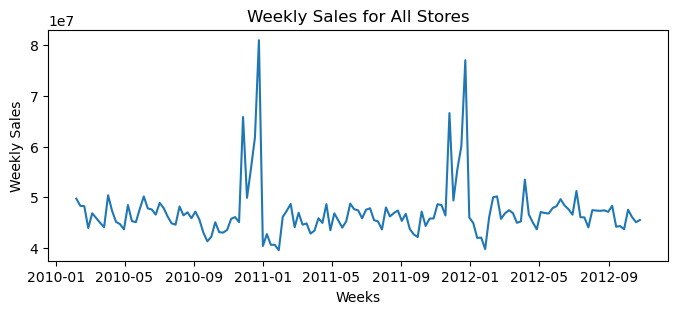

In [12]:
plt.figure(figsize = (8,3))
# plt.plot(total_store_sales.Weekly_Sales)
plt.plot(total_store_sales.Date, total_store_sales.Weekly_Sales)
plt.ylabel('Weekly Sales')
plt.xlabel('Weeks')
plt.title('Weekly Sales for All Stores');

<Figure size 1200x800 with 0 Axes>

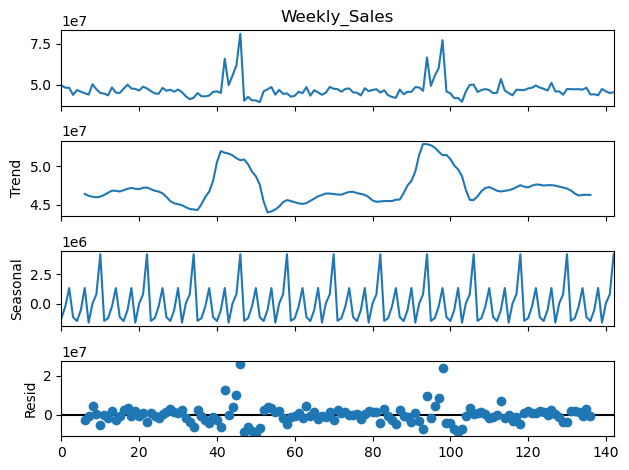

In [55]:
# total_store_sales = df.groupby('Date')['Weekly_Sales'].sum().to_frame()
plt.figure(figsize=(12, 8))
decomp = seasonal_decompose(total_store_sales['Weekly_Sales'], model='additive', period=12)
decomp.plot();

## Autocorrelation and partial autocorrelation

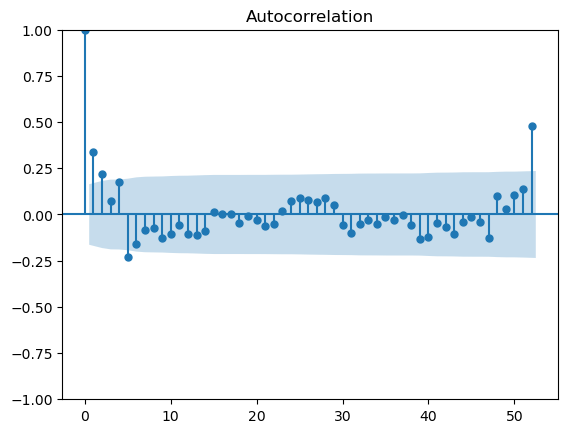

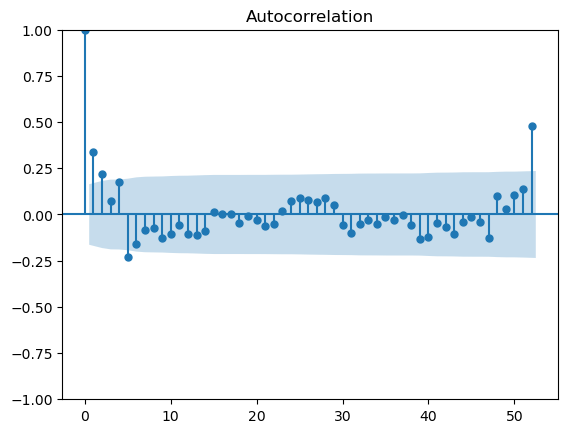

In [58]:
total_store_sales.set_index('Date', inplace=True)
plot_acf(total_store_sales, lags=52)

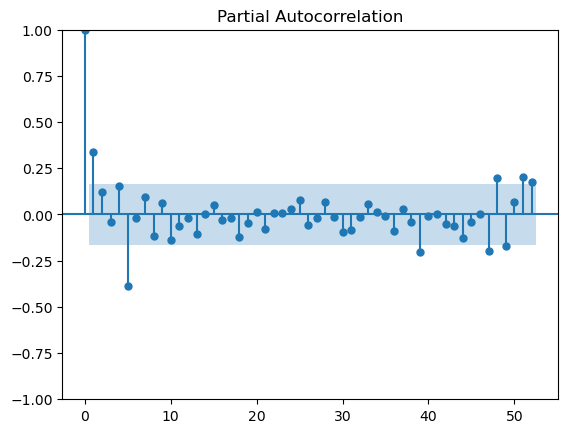

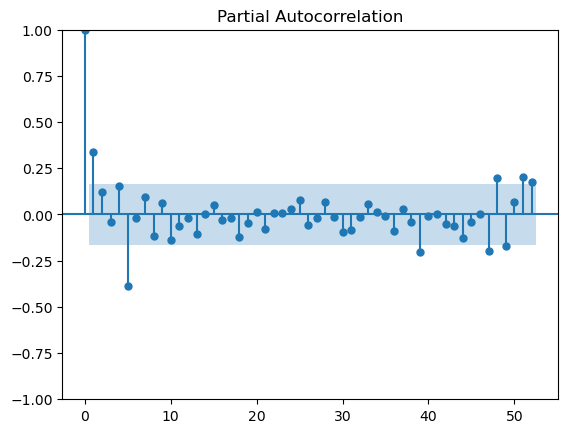

In [59]:
plot_pacf(total_store_sales, lags=52)

### Analysis of Avg Sales by Store

In [60]:
avg_store_sales = df.groupby('Store')['Weekly_Sales'].mean()

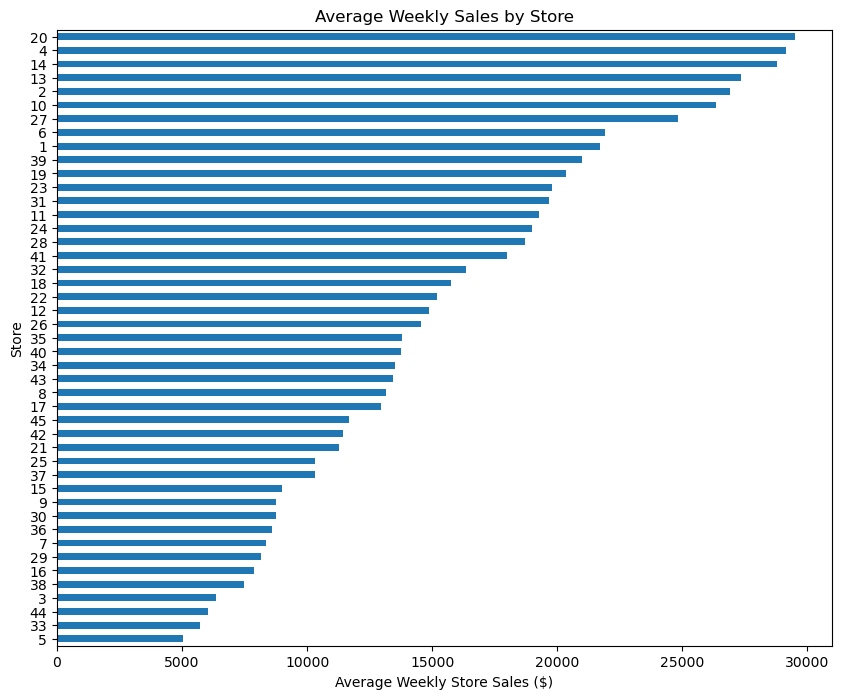

In [61]:
plt.figure(figsize=(10,8))
avg_store_sales.sort_values().plot(kind='barh')
plt.xlabel('Average Weekly Store Sales ($)')
plt.ylabel('Store')
plt.title('Average Weekly Sales by Store')
plt.show();

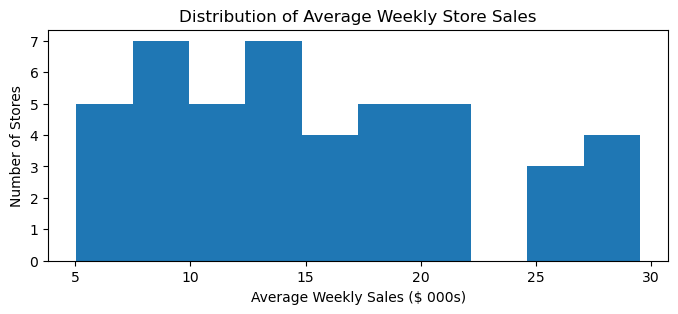

In [63]:
# Avg Weekly Sales Histogram
plt.figure(figsize=(8,3))
plt.hist(avg_store_sales/1000)
plt.xlabel('Average Weekly Sales ($ 000s)')
plt.ylabel('Number of Stores')
plt.title('Distribution of Average Weekly Store Sales');

In [64]:
# Avg store size 
avg_store_size = df.groupby('Store')['Size'].mean()

In [65]:
sales_per_sqft = pd.merge(avg_store_sales, avg_store_size, on=['Store'])

In [66]:
sales_per_sqft['sales_per_sqft'] = sales_per_sqft['Weekly_Sales']/sales_per_sqft['Size']

In [67]:
sales_per_sqft.drop(columns=['Weekly_Sales', 'Size'], inplace=True)

In [68]:
sales_per_sqft.head()

,sales_per_sqft
Store,
1,0.143479
2,0.132957
3,0.170438
4,0.141653
5,0.144901


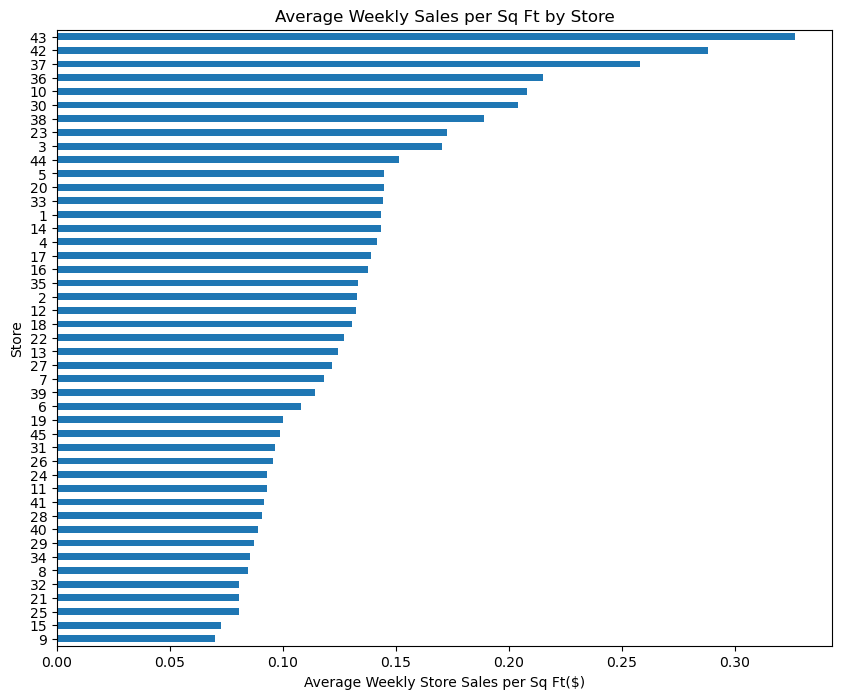

In [69]:
plt.figure(figsize=(10,8))
sales_per_sqft['sales_per_sqft'].sort_values().plot(kind='barh')
plt.xlabel('Average Weekly Store Sales per Sq Ft($)')
plt.ylabel('Store')
plt.title('Average Weekly Sales per Sq Ft by Store')
plt.show();

In [70]:
avg_store_sales = avg_store_sales.reset_index()

In [71]:
avg_store_sales

,Store,Weekly_Sales
0,1,21710.543621
1,2,26898.070031
2,3,6373.033983
3,4,29161.210415
4,5,5053.415813
5,6,21913.243624
6,7,8358.766148
7,8,13133.014768
8,9,8772.890379
9,10,26332.303819


### Analysis by Store

In [72]:
weekly_sales_per_store = pd.DataFrame(df.groupby(['Date', 'Store'])['Weekly_Sales'].sum())

In [73]:
weekly_sales_per_store

Weekly_Sales
Date       Store              
2010-02-05 1        1643690.90
           2        2136989.46
           3         461622.22
           4        2135143.87
           5         317173.10
...                        ...
2012-10-26 41       1316542.59
           42        514756.08
           43        587603.55
           44        361067.07
           45        760281.43

[6435 rows x 1 columns]

In [74]:
weekly_sales_per_store = weekly_sales_per_store.reset_index()
# .drop(columns = 'Date')
# [weekly_sales_per_store['Store'] == 1]

In [75]:
weekly_sales_per_store.head(5)

,Date,Store,Weekly_Sales
0,2010-02-05,1,1643690.90
1,2010-02-05,2,2136989.46
2,2010-02-05,3,461622.22
3,2010-02-05,4,2135143.87
4,2010-02-05,5,317173.10


In [77]:
# plt.figure(figsize=(12,5))
# # sns.boxplot(x = df['Weekly_Sales'], y = df['Store'])
# sns.boxplot(x = weekly_sales_per_store['Weekly_Sales'], y = weekly_sales_per_store['Store']);